Name: Patrick Ng  
Class: W261-2  
Date: Mar 10, 2016  
HW07

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## HW 7.0: Shortest path graph distances (toy networks)

```
In this part of your assignment you will develop the base of your code for the week.

Write MRJob classes to find shortest path graph distances, 
as described in the lectures. In addition to finding the distances, 
your code should also output a distance-minimizing path between the source and target.
Work locally for this part of the assignment, and use 
both of the undirected and directed toy networks.

To proof you code's function, run the following jobs

- shortest path in the undirected network from node 1 to node 4
Solution: 1,5,4 

- shortest path in the directed network from node 1 to node 5
Solution: 1,2,4,5

and report your output---make sure it is correct!
```

#### Init function: convert an input file into an SSSP file
SSSP File format:  
```
JSON representaton of:
node id \t [ {adj-list dict}, [path from src], cost from src, status ]

e.g.
3       [{"2": 1, "4": 1}, [], 9223372036854775807, "U"]
```

In [150]:
%%writefile InitSssp.py
import sys
import json

def initSomeValues(isSourceNode, src):
    if isSourceNode:
        # This is the source node
        status = 'Q'
        sps = [int(src)] # shortest path from source
        costFromSrc = 0
    else:
        # Other nodes
        status = 'U'
        sps = [] # Unknown
        costFromSrc = sys.maxint # Unknown
        
    return (status, sps, costFromSrc)

class InitSssp:
    @staticmethod
    def run(fn, src):
        seenNodes = set()
        emittedNodes = set()
                
        # Input format:
        # 4       {'2': 1, '5': 1}
        with open('sssp.txt', 'w') as output:
            with open(fn, "r") as f:
                for line in f:
                    fields = line.strip().split('\t')

                    node = fields[0]

                    # JSON uses double quote for string
                    adjList = json.loads(fields[1].replace("'", '"'))

                    status, sps, costFromSrc = initSomeValues(src == fields[0], src)

                    values = [adjList, sps, costFromSrc, status]
                    output.write("%s\t%s\n" % (node, json.dumps(values)))

                    # Remember all the nodes we've seen in the adjacency list,
                    # and all the nodes we've emitted
                    seenNodes.update(adjList.keys())
                    emittedNodes.add(node)
                    
            # We may have items which are seen in the adj list, but they don't have an entry in the
            # input record to point back to anyone.  This could happen in input for directed graph.
            # In this case we still need to export a record for those remaining nodes.
            for node in seenNodes - emittedNodes:
                status, sps, costFromSrc = initSomeValues(src == node, src)
                adjList = {}
                values = [adjList, sps, costFromSrc, status]
                output.write("%s\t%s\n" % (node, json.dumps(values)))

if __name__ == '__main__':
    fn = sys.argv[1]
    src = sys.argv[2]

    InitSssp.run(fn, src)

Overwriting InitSssp.py


### MRJob for find shortest path

In [104]:
%%writefile MrSssp_hw70.py
from numpy import argmin, array, random
import re
import numpy as np
from mrjob.job import MRJob, MRStep
from itertools import chain
import mrjob
import sys

class MrSssp_hw70(MRJob):
    def steps(self):
        return [
            MRStep(
                   mapper=self.mapper,
                   #combiner = self.combiner,
                   reducer=self.reducer
            )
               ]

    INPUT_PROTOCOL = mrjob.protocol.JSONProtocol

    def mapper(self, nodeId, data):
        # data format:
        # Json object:
        # [ {adj-list dict}, [path from src], cost from src, status ]
        
        #print >> sys.stderr, "input data:", data
        adjList, pathFromSrc, costFromSrc, status = data
        
        if status == "Q":
            # The node is in Queued mode.  It's a frontier node.
            # Need to process its neighbours
            for neighbor, weight in adjList.items():
                neighbor = int(neighbor)
                neighborPathFromSrc = pathFromSrc + [neighbor]
                neighborCostFromSrc = costFromSrc + weight
                yield neighbor, (None, neighborPathFromSrc, neighborCostFromSrc, "Q")
        
            # Lastly, change its own status to visited
            status = "V"
            
        yield nodeId, (adjList, pathFromSrc, costFromSrc, status)
        
    def reducer(self, key, values):
        newStatus = None
        minCostFromSrc = sys.maxint
        
        for data in values:
            adjList, pathFromSrc, costFromSrc, status = data
            
            if adjList is None:
                # It is a record emitted from a neighbor
                if costFromSrc < minCostFromSrc:
                    minCostFromSrc = costFromSrc
                    minPathFromSrc = pathFromSrc                    
                    assert status == 'Q', "status must be Q for record emitted by neighbor"
                    newStatus = status
            else:
                realAdjList = adjList
                latestCostFromSrc = costFromSrc
                latestPathFromSrc = pathFromSrc
                latestStatus = status
        
        if minCostFromSrc < latestCostFromSrc:
            # Its 'cost from Src' becomes smaller.  Put it to the frontier.
            latestStatus = newStatus
            assert latestStatus == 'Q'
            latestCostFromSrc = minCostFromSrc
            latestPathFromSrc = minPathFromSrc            
            
        yield key, (realAdjList, latestPathFromSrc, latestCostFromSrc, latestStatus)
            
              
if __name__ == '__main__':
    MrSssp_hw70.run()

Overwriting MrSssp_hw70.py


### Driver for finding shortest path

In [134]:
%%writefile Driver_Hw70.py
from numpy import random
from MrSssp_hw70 import MrSssp_hw70
from InitSssp import InitSssp
import json
import sys

import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--inputFile", type=str)
parser.add_argument("--srcNode", type=str)
args = parser.parse_args()

mr_job = MrSssp_hw70(args=['sssp.txt',
                        '--no-strict-protocols',
                        '-r', 'inline'])

# Initialized sssp.txt
InitSssp.run(args.inputFile, args.srcNode)

i = 1
hasQueuedNode = True

# Loop as long as we still have at least one queued node
while(hasQueuedNode):
    print "iteration"+str(i)+":"
    
    hasQueuedNode = False # Init it back to False
    with mr_job.make_runner() as runner: 
        runner.run()

        # Generate the new sssp.txt based on job's output
        with open('sssp.txt', 'w') as f:
            for line in runner.stream_output():
                key, value =  mr_job.parse_output_line(line)
                f.write("%s\t%s\n" % (key,json.dumps(value)))
                print "Result: %s\t%s" % (key,value)
                
                if not hasQueuedNode:
                    # Check if we've seen at least one Queued node
                    hasQueuedNode = value[-1] == 'Q'
                        
    print
    print "------------------------"
    print
    i += 1
        

Overwriting Driver_Hw70.py


### Run it for undirected_toy.txt

In [88]:
!python Driver_Hw70.py --inputFile undirected_toy.txt --srcNode 1

iteration1:
Result: 1	[{'2': 1, '5': 1}, [1], 0, 'V']
Result: 2	[{'1': 1, '3': 1, '5': 1, '4': 1}, [1, 2], 1, 'Q']
Result: 3	[{'2': 1, '4': 1}, [], 9223372036854775807, 'U']
Result: 4	[{'3': 1, '2': 1, '5': 1}, [], 9223372036854775807, 'U']
Result: 5	[{'1': 1, '2': 1, '4': 1}, [1, 5], 1, 'Q']

------------------------

iteration2:
Result: 1	[{'2': 1, '5': 1}, [1], 0, 'V']
Result: 2	[{'1': 1, '3': 1, '5': 1, '4': 1}, [1, 2], 1, 'V']
Result: 3	[{'2': 1, '4': 1}, [1, 2, 3], 2, 'Q']
Result: 4	[{'3': 1, '2': 1, '5': 1}, [1, 2, 4], 2, 'Q']
Result: 5	[{'1': 1, '2': 1, '4': 1}, [1, 5], 1, 'V']

------------------------

iteration3:
Result: 1	[{'2': 1, '5': 1}, [1], 0, 'V']
Result: 2	[{'1': 1, '3': 1, '5': 1, '4': 1}, [1, 2], 1, 'V']
Result: 3	[{'2': 1, '4': 1}, [1, 2, 3], 2, 'V']
Result: 4	[{'3': 1, '2': 1, '5': 1}, [1, 2, 4], 2, 'V']
Result: 5	[{'1': 1, '2': 1, '4': 1}, [1, 5], 1, 'V']

------------------------



**Answer:**  
From the output, you can see that the paths from 1 to 4 is: 1, 2, 4  
  
(It is different from the standard solution, but it is okay because there is more than one path from 1 to 4.)

### Run it for directed_toy.txt

In [133]:
!python Driver_Hw70.py --inputFile directed_toy.txt --srcNode 1

iteration1:
Result: 1	[{'2': 1, '6': 1}, [1], 0, 'V']
Result: 2	[{'1': 1, '3': 1, '4': 1}, [1, 2], 1, 'Q']
Result: 3	[{'2': 1, '4': 1}, [], 9223372036854775807, 'U']
Result: 4	[{'2': 1, '5': 1}, [], 9223372036854775807, 'U']
Result: 5	[{'1': 1, '2': 1, '4': 1}, [], 9223372036854775807, 'U']
Result: 6	[{}, [1, 6], 1, 'Q']

------------------------

iteration2:
Result: 1	[{'2': 1, '6': 1}, [1], 0, 'V']
Result: 2	[{'1': 1, '3': 1, '4': 1}, [1, 2], 1, 'V']
Result: 3	[{'2': 1, '4': 1}, [1, 2, 3], 2, 'Q']
Result: 4	[{'2': 1, '5': 1}, [1, 2, 4], 2, 'Q']
Result: 5	[{'1': 1, '2': 1, '4': 1}, [], 9223372036854775807, 'U']
Result: 6	[{}, [1, 6], 1, 'V']

------------------------

iteration3:
Result: 1	[{'2': 1, '6': 1}, [1], 0, 'V']
Result: 2	[{'1': 1, '3': 1, '4': 1}, [1, 2], 1, 'V']
Result: 3	[{'2': 1, '4': 1}, [1, 2, 3], 2, 'V']
Result: 4	[{'2': 1, '5': 1}, [1, 2, 4], 2, 'V']
Result: 5	[{'1': 1, '2': 1, '4': 1}, [1, 2, 4, 5], 3, 'Q']
Result: 6	[{}, [1, 6], 1, 'V']

------------------------

it

**Answer:**  
From the output, you can see that the paths from 1 to 5 is: 1, 2, 4, 5 

## HW 7.1: Exploratory data analysis (NLTK synonyms)
```
Using MRJob, explore the synonyms network data.
Consider plotting the degree distribution (does it follow a power law?),
and determine some of the key features, like:

number of nodes, 
number links,
or the average degree (i.e., the average number of links per node),
etc...

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).
```

In [4]:
%%writefile MrExplore_hw71.py
from __future__ import division
from numpy import argmin, array, random
import re
import numpy as np
from mrjob.job import MRJob, MRStep
from itertools import chain
import mrjob
import sys
import json

class MrExplore_hw71(MRJob):
    def steps(self):
        return [
            MRStep(
                   mapper=self.mapper,
                   combiner = self.reducer,
                   reducer=self.reducer
            )
               ]

    def mapper(self, _, data):
        # data format:
        # 1       {'2': 1, '3': 1, '4': 1}

        yield "n", 1 # for total number of nodes
        
        # JSON uses double quote for string
        fields = data.strip().split('\t')
        adjList = json.loads(fields[1].replace("'", '"'))
        degree = len(adjList)
        yield "l", degree # for total number of links
        
        yield "d" + str(degree), 1  # for distribution of degree

    def reducer(self, key, values):
        total = sum([v for v in values])
        yield key, total            
              
if __name__ == '__main__':
    MrExplore_hw71.run()

Overwriting MrExplore_hw71.py


#### Run it locally

In [74]:
!python MrExplore_hw71.py synNet.txt \
-r inline \
--strict-protocol \
-q \
> hw71_result.txt

Number of nodes = 8271
Number of links = 61134


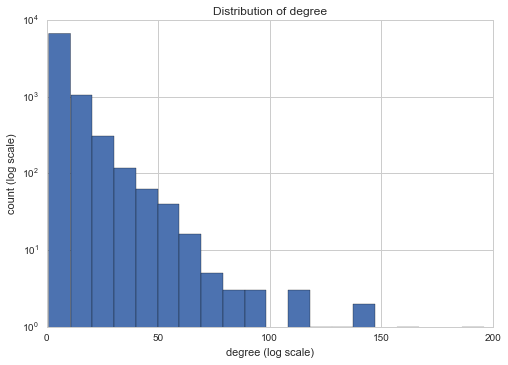

In [84]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

degreeDist = {}

with open("hw71_result.txt", "r") as f:
    for line in f:
        fields = line.strip().split('\t')
        key = fields[0].replace('"', '')
        value = fields[1]
        if key == "l":
            totalLinks = int(value)
        elif key == "n":
            totalNodes = int(value)
        else:
            # format: "d3"
            degree = int(key[1:])
            degreeDist[degree] = int(value)

print "Number of nodes =", totalNodes
print "Number of links =", totalLinks

degrees = [int(x) for x in degreeDist.keys()] 
counts = degreeDist.values()

fig, ax = plt.subplots()

ax.hist(degrees, weights = counts, bins = 20, log=True, align='mid')
plt.xlabel('degree (log scale)')
plt.ylabel('count (log scale)')
plt.title('Distribution of degree')
plt.show()

#### Try running it on EMR

In [81]:
!aws s3 rb --force s3://patng323-w261-hw71
!aws s3 mb s3://patng323-w261-hw71
!aws s3 cp synNet.txt s3://patng323-w261-hw71/input/synNet.txt

A client error (NoSuchBucket) occurred when calling the ListObjects operation: The specified bucket does not exist
Completed 1 part(s) with ... file(s) remaining
remove_bucket failed: s3://patng323-w261-hw71/ A client error (NoSuchBucket) occurred when calling the DeleteBucket operation: The specified bucket does not exist

make_bucket: s3://patng323-w261-hw71/
upload: ./synNet.txt to s3://patng323-w261-hw71/input/synNet.txt


In [82]:
!python MrExplore_hw71.py \
s3://patng323-w261-hw71/input/ \
-r emr \
--ec2-instance-type m1.large \
--num-ec2-instances 2 \
--emr-tag job=hw7_1 \
--aws-region us-east-1 \
--strict-protocols \
--no-output \
--output-dir=s3://patng323-w261-hw71/output

Got unexpected keyword arguments: ssh_tunnel
no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating new scratch bucket mrjob-7b44dd6b28252569
using s3://mrjob-7b44dd6b28252569/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrExplore_hw71.patrickng.20160307.143323.522917
writing master bootstrap script to /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrExplore_hw71.patrickng.20160307.143323.522917/b.py
creating S3 bucket 'mrjob-7b44dd6b28252569' to use as scratch space
Copying non-input files into s3://mrjob-7b44dd6b28252569/tmp/MrExplore_hw71.patrickng.20160307.143323.522917/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Can't access IAM API, trying default instance profile: EMR_EC2_DefaultRole
Can't access IAM API, trying default service role: EMR_DefaultRole
Job flow created with ID: j-R48XJEHVP59P
Setting EMR tags: job=hw7_1
Creat

In [83]:
!rm -f hw71_result.txt
!aws s3 cp s3://patng323-w261-hw71/output/part-00000 hw71_result.txt

download: s3://patng323-w261-hw71/output/part-00000 to ./hw71_result.txt


## HW 7.2: Shortest path graph distances (NLTK synonyms)
```
Write (reuse your code from 7.0) an MRJob class to find shortest path graph distances, 
and apply it to the NLTK synonyms network dataset. 

Proof your code's function by running the job:

- shortest path starting at "walk" (index=7827) and ending at "make" (index=536),

and showing you code's output. Once again, your output should include the path and the distance.

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).
```

In [160]:
%%writefile Driver_Hw72.py
from numpy import random
from MrSssp_hw70 import MrSssp_hw70
from InitSssp import InitSssp
import json
import sys

import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--srcNode", type=str)
parser.add_argument("--inputFile", type=str)
parser.add_argument("--destNode", type=str, default=None)
args = parser.parse_args()

# Initialized sssp.txt
InitSssp.run(args.inputFile, args.srcNode)

mr_job = MrSssp_hw70(args=['sssp.txt',
                        '--no-strict-protocols',
                        '-r', 'inline'])

i = 1
hasQueuedNode = True
destNodeDone = False

# Loop as long as we still have at least one queued node
while(hasQueuedNode and not destNodeDone):    
    hasQueuedNode = False # Init it back to False
    with mr_job.make_runner() as runner: 
        runner.run()

        # Generate the new sssp.txt based on job's output
        with open('sssp.txt', 'w') as f:
            for line in runner.stream_output():
                key, value =  mr_job.parse_output_line(line)
                
                # output format:
                # 1     [{'2': 1, '6': 1}, [1], 0, 'V']
                
                f.write("%s\t%s\n" % (key,json.dumps(value)))
                status = value[-1]
                
                # If we've specified a destination node, see if we've got
                # the cost to it already.
                if str(key) == args.destNode:
                    destNodeDone = status == 'V'
                    destNodePath = value[1]
                    distance = value[2]
                
                # Check if we've seen at least one Queued node
                if not hasQueuedNode:
                    hasQueuedNode = status == 'Q'

    i += 1

print "Total no. of iterations:", i-1
print
if args.destNode is not None:
    print "From %s to %s" % (args.srcNode, args.destNode)
    if destNodeDone:
        print "Path =", str(destNodePath)
        print "Distance =", distance
    else:
        print "Path not found"
        

Overwriting Driver_Hw72.py


#### Run it locally

In [161]:
!python Driver_Hw72.py --inputFile synNet.txt --srcNode 7827 --destNode 536

Total no. of iterations: 4

From 7827 to 536
Path = [7827, 1426, 1668, 536]
Distance = 3


#### Run it on EMR

In [159]:
!aws s3 rb --force s3://patng323-w261-hw72
!aws s3 mb s3://patng323-w261-hw72
!aws s3 cp synNet.txt s3://patng323-w261-hw72/input/synNet.txt

A client error (NoSuchBucket) occurred when calling the ListObjects operation: The specified bucket does not exist
Completed 1 part(s) with ... file(s) remaining
remove_bucket failed: s3://patng323-w261-hw72/ A client error (NoSuchBucket) occurred when calling the DeleteBucket operation: The specified bucket does not exist

make_bucket: s3://patng323-w261-hw72/
upload: ./synNet.txt to s3://patng323-w261-hw72/input/synNet.txt
